
Import a few modules such as numoy, scipy, tensorflow, and matplotlib.
Then import PIL to manipulate images


In [1]:

from __future__ import division
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io
import scipy.misc
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline


Then set the input path for the image used to learn the style and for the content image to be repainted according to the style:

In [2]:
OUTPUT_DIR="./output/"
#style image
style_img="./graffiti.jpg"
#content image
content_img="./download.jpeg"


Then we setup the noise ratio used during the image generation and the emphasis we would like to put on content loss and on style loss when repainting the content image. In addition to that, we store the path to the pretrained VGG model and the mean computer to VGG pretraining

This mean is already known and is subtracted from the input to the VGG model:

In [3]:
#how much noise is in the image
noise_ratio=0.6
#how much emphasis of content loss
beta=5
#how much emphasis on style loss
alpha=100
#the vgg-19 layer pretrained model
vgg_model="./imagenet-vgg-verydeep-19.mat"

#the mean used when the vgg was trained
#it is subtracted from the input to the vgg model
mean_values=np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

/home/dheeraj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


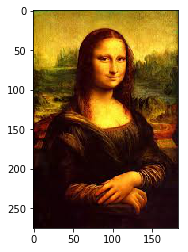

In [4]:
#show the content just to understand how it is

content_image=scipy.misc.imread(content_img)
imshow(content_image)

/home/dheeraj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/dheeraj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  
/home/dheeraj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


Target shape : (275, 183, 3)
Style shape : (275, 183, 3)
Style image shape is : (275, 183, 3)


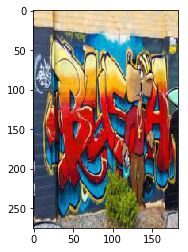

In [5]:
#resize the style image and show it just to understand how it is. Note that
#the content image and style image should have the same size and the same number of color channels

style_image=scipy.misc.imread(style_img)

#Get shape of target and make the style image the same
target_shape=content_image.shape
print("Target shape : {}".format(target_shape))
print("Style shape : {}".format(style_image.shape))

#ratio=target_shape[1] / style_image.shape[1]
#print("resize ratio", ratio)

style_image=scipy.misc.imresize(style_image, target_shape)
scipy.misc.imsave(style_img, style_image)
imshow(style_image)

print("Style image shape is : {}".format(style_image.shape))

The next step is to define the VGG model as described in the original paper. 
Note that the deep learning network is quite complex as it combines multiple ConvNet layers with ReLu
activation function and MaxPooling.

An additional note is that in the original paper for tranfer Styling("A Neural Algorithm of Artisitic Style", many experiments show that average pooling is actually outperforming maxpooling. 

So we will use average pooling instead.


In [6]:
def load_vgg_model(path, image_height, image_width, color_channels):
    vgg=scipy.io.loadmat(path)
    vgg_layers=vgg['layers']
    

    def _weights(layer, expected_layer_name):
        #Return the weights and biases from the VGG model for a given layer
        W=vgg_layers[0][layer][0][0][0][0][0]
        b=vgg_layers[0][layer][0][0][0][0][1]
        layer_name=vgg_layers[0][layer][0][0][-2]

        assert layer_name==expected_layer_name
        return W, b
        
        return W,b
        '''
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b
        return W,b
        '''
    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):

        W,b=_weights(layer, layer_name)
        W=tf.constant(W)
        b=tf.constant(np.reshape(b, (b.size)))

        return tf.nn.conv2d(prev_layer, filter=W, strides=[1,1,1,1], padding='SAME') +b

    def _conv2d_relu(prev_layer, layer, layer_name):
        #return the conv2d + RELU layer using the weights, biases from the VGG

        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    #construct the graph model

    graph={}
    
    graph['input']=tf.Variable(np.zeros((1, image_height, image_width, color_channels)), dtype='float32')
    
    graph['conv1_1']=_conv2d_relu(graph['input'], 0, 'conv1_1')
    
    graph['conv1_2']=_conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    
    graph['avgpool_1']=_avgpool(graph['conv1_2'])
    
    graph['conv2_1']=_conv2d_relu(graph['avgpool_1'], 5, 'conv2_1')
    
    graph['conv2_2']=_conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    
    graph['avgpool_2']=_avgpool(graph['conv2_2'])
    
    graph['conv3_1']=_conv2d_relu(graph['avgpool_2'], 10, 'conv3_1')
    
    graph['conv3_2']=_conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    
    #graph['avgpool_3']=_avgpool(graph['conv3_2'])
    
    graph['conv3_3']=_conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    
    graph['conv3_4']=_conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    
    graph['avgpool_3']=_avgpool(graph['conv3_4'])
    
    graph['conv4_1']=_conv2d_relu(graph['avgpool_3'], 19, 'conv4_1')
    
    graph['conv4_2']=_conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    
    graph['conv4_3']=_conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    
    graph['conv4_4']=_conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    
    graph['avgpool_4']=_avgpool(graph['conv4_4'])
    
    graph['conv5_1']=_conv2d_relu(graph['avgpool_4'], 28, 'conv5_1')
    
    graph['conv5_2']=_conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    
    graph['conv5_3']=_conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    
    graph['conv5_4']=_conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    
    graph['avgpool_5']=_avgpool(graph['conv5_4'])
    
    return graph
    
    

## Define content loss function as it has been described in the original paper

In [7]:


def content_loss_fn(sess, model):
    
    def content_loss(p,x):
        #N is the number of filters at layer 1
        
        N=p.shape[3]
        
        #M is the height times the width of the feature map(at layer 1)
        
        M=p.shape[1]* p.shape[2]
        return (1/(4*N*M))*tf.reduce_sum(tf.pow(x-p, 2))
    
    return content_loss(sess.run(model['conv4_2']), model['conv4_2'])



## Define the VGG layers we are going to reuse. 



If we would like to have softer features, we will need to increase the weight of higher layers(conv5_1) and decrease the weight of the lower layers(conv1_1).

If we would like to have harder features, we need to do the opposite. 

In [8]:
style_layers=[
    ('conv1_1', 0.5),
    ('conv2_1', 1.0),
    ('conv3_1', 1.5),
    ('conv4_1', 3.0),
    ('conv5_1', 4.0),
    
]

## Define the style loss as it has been described in the paper

In [9]:
def style_loss_fn(sess, model):
    def gram_matrix(F, N, M):
        
        #The GRAM Matrix G is given as :
        
        Ft=tf.reshape(F, (M, N))
        return tf.matmul(tf.transpose(Ft), Ft)
    
    def style_loss(a,x):
        #The style loss calculation
        
        # N is the number of filters (at layer 1)
        N=a.shape[3]
        
        # M is the height times the width of the feature map (at layer 1)
        M=a.shape[1]*a.shape[2]
        
        # A is the style representation of the generated image (at layer 1)
        A= gram_matrix(a, N, M)
        
        # G is the style representation of the generated image (at layer 1)
        G= gram_matrix(x, N, M)
        
        result=(1/(4*(N**2)*(M**2)))*tf.reduce_sum(tf.pow(G-A, 2))
        
        return result
    
    E=[style_loss(sess.run(model[layer_name]), model[layer_name]) for layer_name,_ in style_layers]
    
    W=[w for _,w in style_layers]
    loss=sum([W[l]*E[l] for l in range(len(style_layers))])
    
    return loss

### Define a function to generate a noise image and internmix it wth the content image with a given ratio.

Define two auxilliary methods to preprocess and save images:

In [10]:
def generate_noise_image(content_image, noise_ratio=noise_ratio):
    #Returns a noise image intermixed with the content image at a certain ratio
    
    noise_image=np.random.uniform(-20, 20, (1, content_image.shape[0], 
                                            content_image.shape[1],
                                            content_image.shape[2])).astype('float32')
    
    #white noise image from the content representation. Take the weighted average of the values
    
    input_image=noise_image*noise_ratio + content_image*(1-noise_ratio)
    
    return input_image


def process_image(image):
    #resize the image for convnet input, there is no change but just add an extra dimension.
    
    image=np.reshape(image, ((1,) + image.shape))
    
    #Input to the VGG model expects the mean to be subtracted.
    image=image-mean_values
    
    return image

def save_image(path, image):
    #output should add back the mean.
    image=image+mean_values
    
    #Get rid of the first useless dimension, whatremains in the image
    image=image[0]
    image=np.clip (image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)


### Start a Tensorflow interactive session

In [11]:
sess=tf.InteractiveSession()

In [12]:
model=load_vgg_model(vgg_model, style_image.shape[0],style_image.shape[1], style_image.shape[2])
print(model)

{'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 275, 183, 64) dtype=float32>, 'conv5_4': <tf.Tensor 'Relu_15:0' shape=(1, 18, 12, 512) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 138, 92, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 69, 46, 256) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 138, 92, 128) dtype=float32>, 'conv5_2': <tf.Tensor 'Relu_13:0' shape=(1, 18, 12, 512) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 69, 46, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 35, 23, 512) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 275, 183, 64) dtype=float32>, 'input': <tf.Variable 'Variable:0' shape=(1, 275, 183, 3) dtype=float32_ref>, 'avgpool_4': <tf.Tensor 'AvgPool_3:0' shape=(1, 18, 12, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1, 35, 23, 512) dtype=float32>, 'avgpool_5': <tf.Tensor 'AvgPool_4:0' shape=(1, 9, 6, 512) dtype=float32>, 'conv5_3': <tf.Tensor 'Relu_14:0' shape=(1, 1

In [13]:
### Load the processed content image and show it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of content image is : (275, 183, 3)
shape of content image is : (1, 275, 183, 3)


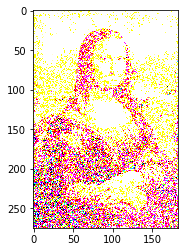

In [14]:
print("shape of content image is :",content_image.shape)


content_image=generate_noise_image(content_image)
imshow(content_image[0])

print("shape of content image is :",content_image.shape)


### Adding extra dimension in style image

In [15]:
style_image=process_image(style_image)
#imshow(content_image[0])
print("shape of style image is :",style_image.shape)



shape of style image is : (1, 275, 183, 3)


### Run Tensorflow Sessions

In [16]:
sess.run(tf.global_variables_initializer())

### Contruct the content_loss and style_loss with respective images

In [17]:
#construct content loss using content image


print("shape of content image is :",content_image.shape)
print("shape of style image is :",style_image.shape)
sess.run(model['input'].assign(content_image))
content_loss=content_loss_fn(sess, model)

#construct style loss using style image
sess.run(model['input'].assign(style_image))
style_loss=style_loss_fn(sess, model)


shape of content image is : (1, 275, 183, 3)
shape of style image is : (1, 275, 183, 3)


### Construct the total loss as weighted combination of content loss and style loss

In [18]:
#contruct the total loss as weighted combination of content loss and style loss
total_loss=beta+content_loss + alpha*style_loss

### Build an optimizer to minimize the total loss. 

In [19]:
#The content is built from one layer while the style is build from 5 layers

optimizer=tf.train.AdamOptimizer(2.0)
train_step=optimizer.minimize(total_loss)

### Bootstrap the network with te input image

In [21]:
sess.run(tf.global_variables_initializer())
sess.run(model['input'].assign(content_image))

array([[[[ 34.971706  ,  56.189114  ,  19.532232  ],
         [ 42.347435  ,  36.441837  ,   8.419078  ],
         [ 34.144127  ,  45.521946  ,   2.1624355 ],
         ...,
         [ 39.730408  ,  40.317932  ,   8.57539   ],
         [ 49.8531    ,  44.67804   ,  26.725836  ],
         [ 39.65222   ,  51.98879   ,  11.392826  ]],

        [[ 40.51924   ,  44.925663  ,  31.954338  ],
         [ 33.969593  ,  56.311256  ,  16.584553  ],
         [ 26.218134  ,  55.3797    ,  22.989359  ],
         ...,
         [ 42.42367   ,  60.792408  ,  24.504505  ],
         [ 52.38609   ,  45.206432  ,  15.834952  ],
         [ 32.437107  ,  35.67043   ,  12.377975  ]],

        [[ 60.994072  ,  55.535995  ,  26.379904  ],
         [ 36.457508  ,  56.669056  ,  21.015203  ],
         [ 55.97535   ,  56.32709   ,  21.00649   ],
         ...,
         [ 47.412262  ,  49.353485  ,  18.662382  ],
         [ 40.119267  ,  44.109272  ,   9.198499  ],
         [ 33.95091   ,  37.041164  ,  17.866116  ]],